In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#**Part 1:** labraries  and data set

In [ ]:
# Install necessary libraries
!pip install tensorflow numpy matplotlib

# Import libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.14.0


In [ ]:
# Load and explore the dataset

# Resize the image to the expected input size for ResNet50 (224x224)
IMAGE_SIZE = [224, 224]

# Define the paths in Google Colab
train_path = '/content/drive/MyDrive/Colab Notebooks/datasets/Train'
test_path = '/content/drive/MyDrive/Colab Notebooks/datasets/Test'


In [ ]:
# useful for getting number of output classes
folders = glob(f'{train_path}/*')

# Print the list of folders
print(folders)
print(len(folders))

['/content/drive/MyDrive/Colab Notebooks/datasets/Train/Parasite', '/content/drive/MyDrive/Colab Notebooks/datasets/Train/Uninfected']
2


#**Part 2:** Data Preprocessing and Augmentation

In [ ]:
# Step 1: Use the ImageDataGenerator to perform data augmentation for the training/test set

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to the range [0,1]
    shear_range=0.2,            # Apply random shear transformations
    zoom_range=0.2,             # Apply random zoom transformations
    horizontal_flip=True        # Flip images horizontally
)



In [ ]:
# Step 2 : for the test set, only rescaling is applied(no augmenation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Step 3: Create a generator for the training set

training_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 416 images belonging to 2 classes.


In [ ]:
# Step 4: Create a generator for the test set
test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 134 images belonging to 2 classes.


#**Part 3**: Model Building

In [ ]:

# Step 1: Import VGG19 model and create an instance for transfer learning
# resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
mobilnet = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# Step 2: Freeze existing weights to prevent training
for layer in mobilnet.layers:
    layer.trainable = False



In [ ]:
# Step 3: Flatten layer to convert 3D output to 1D
x = Flatten()(mobilnet.output)

# Print the shape before and after flattening
print(f"Shape before flattening: {mobilnet.output.shape}")
print(f"Shape after flattening :  {x.shape}")


Shape before flattening: (None, 7, 7, 512)
Shape after flattening :  (None, 25088)


In [ ]:
# Step 4: Define the final prediction layer
prediction = Dense(len(folders), activation='softmax')(x)
#prediction represents the output of the model. It will be a probability distribution over the 4 classes

In [ ]:
# Step 5: Create a model object by connecting the ResNet base model with the final prediction layer
model = Model(inputs=mobilnet.input, outputs=prediction)

In [ ]:
# Step 6: Display a summary of the model architecture
model.summary()


#Part 4: Model Training

In [ ]:
# step1: configuring the model for training.

# specifies the loss function, optimizer, and metrics to be used during the training process.
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# step 2 :  fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-22-bc2e76a8d839>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
13/13 [==============================] - 184s 14s/step - loss: 1.0909 - accuracy: 0.5889 - val_loss: 0.6569 - val_accuracy: 0.6791
Epoch 2/20
13/13 [==============================] - 7s 551ms/step - loss: 0.6595 - accuracy: 0.6875 - val_loss: 0.9583 - val_accuracy: 0.5373
Epoch 3/20
13/13 [==============================] - 6s 487ms/step - loss: 0.4711 - accuracy: 0.7596 - val_loss: 0.4566 - val_accuracy: 0.8060
Epoch 4/20
13/13 [==============================] - 8s 659ms/step - loss: 0.3271 - accuracy: 0.8774 - val_loss: 0.4013 - val_accuracy: 0.7612
Epoch 5/20
13/13 [==============================] - 6s 482ms/step - loss: 0.3019 - accuracy: 0.8894 - val_loss: 0.4160 - val_accuracy: 0.7985
Epoch 6/20
13/13 [==============================] - 8s 558ms/step - loss: 0.2839 - accuracy: 0.8894 - val_loss: 0.3826 - val_accuracy: 0.8433
Epoch 7/20
13/13 [==============================] - 9s 670ms/step - loss: 0.2494 - accuracy: 0.9014 - val_loss: 0.3715 - val_accuracy: 0.8433
Epoch 

#Part 5: Model Evaluation

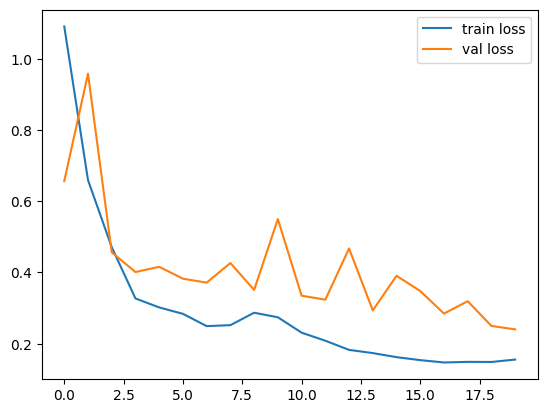

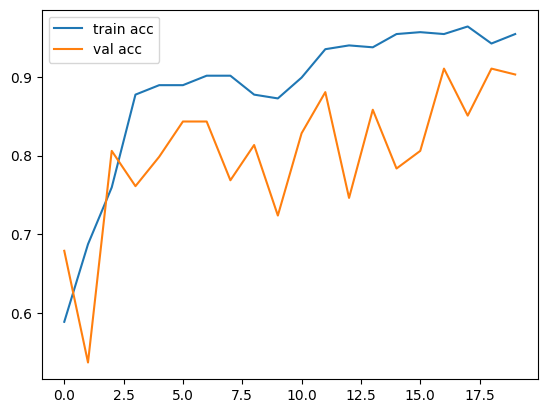

<Figure size 640x480 with 0 Axes>

In [ ]:
#step1: # plot the loss and accuracy

plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

    # plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:


# step2: save  THE MODEL  as a h5 file
from tensorflow.keras.models import load_model

model.save('model2_VGG19.h5')



#  part 6 :  predict test data

In [ ]:
y_pred = model.predict(test_set)
y_pred

5/5 [==============================] - 1s 152ms/step


array([[8.81390631e-01, 1.18609399e-01],
       [4.23772901e-01, 5.76227069e-01],
       [8.67075086e-01, 1.32924929e-01],
       [3.78317147e-01, 6.21682882e-01],
       [9.97071147e-01, 2.92878202e-03],
       [4.73870456e-01, 5.26129603e-01],
       [2.21031353e-01, 7.78968632e-01],
       [4.30823773e-01, 5.69176197e-01],
       [9.46226060e-01, 5.37739694e-02],
       [3.88950229e-01, 6.11049831e-01],
       [9.97319281e-01, 2.68073054e-03],
       [5.45819044e-01, 4.54180986e-01],
       [9.99990106e-01, 9.87022486e-06],
       [7.68693626e-01, 2.31306404e-01],
       [9.65530396e-01, 3.44696045e-02],
       [9.99438226e-01, 5.61796478e-04],
       [2.02614218e-01, 7.97385752e-01],
       [9.73810256e-01, 2.61897966e-02],
       [9.24560308e-01, 7.54396543e-02],
       [6.17195368e-01, 3.82804662e-01],
       [9.87235367e-01, 1.27646364e-02],
       [9.99996901e-01, 3.14352337e-06],
       [1.55393556e-01, 8.44606519e-01],
       [4.30159450e-01, 5.69840550e-01],
       [9.130455

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0])

# Exmaple : pridict using one image

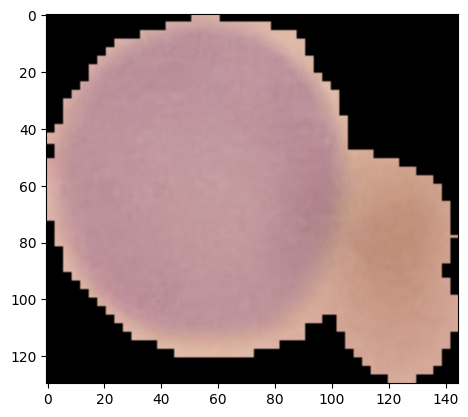

In [ ]:


# load the image
img_path='/content/drive/MyDrive/Colab Notebooks/datasets/Test/Uninfected/2.png'

# disply th image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()


In [ ]:
# Load and preprocess the image for prediction
i = image.load_img(img_path, target_size=(224, 224))
i = image.img_to_array(i) / 255.0
i

In [ ]:
i.shape

(224, 224, 3)

In [ ]:

i = i.reshape(1, 224, 224, 3)
i=preprocess_input(i)
i.shape

(1, 224, 224, 3)

In [ ]:
# Make predictions using the provided model
predictions = model.predict(i)
predictions



1/1 [==============================] - 0s 19ms/step


array([[0.00134266, 0.99865735]], dtype=float32)

In [ ]:
dic = { 0 : "Infected" , 1 :  "Uninfected"}
predictions=np.argmax(predictions, axis=1)
print("Predictions:", predictions)
print("predicted_class:", dic[predictions[0]])


Predictions: [1]
predicted_class: Uninfected


In [ ]:
# crete a fucntion to preporcess the loaded image
dic = { 0 : "Infected" , 1 :  "Uninfected"}

def  predict_label(img_path , dic) :
  #READ THE IMAGE
  i = image.load_img(img_path, target_size=(224,224))
  i = image.img_to_array(i)/255.0
  i=np.expand_dims(i,axis=0)
  img_data=preprocess_input(i)
  predictions = model.predict(img_data)
  result= np.argmax(predictions , axis=1)
  return  dic[result[0]]



In [ ]:

 result= predict_label(img_path , dic)
 result

1/1 [==============================] - 0s 18ms/step


'Uninfected'